# Paintings Analysis
Let's explore a digital art collection comprised of over 500 images of oil paintings that has been scraped from the internet.

In [5]:
# -*- coding: utf8 -*-
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import squarify
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
#import pickle

In [6]:
image_directory = "C:/Users/BF-MSTR/Google Drive/Wallpapers/"
# magick "C:\Users\BF-MSTR\Google Drive\Wallpapers\16\*.jpg" -resize 1000x1000 "C:\Users\BF-MSTR\Google Drive\Wallpapers\16\rs\rs_%03d.jpg"

In [ ]:
# DEBUG 
test_img = '1758 - Italy - Bernardo Bellotto - Das kaiserliche Lustchloss Schloss Hof, Ansicht von Norden.jpg'
np.shape(cv2.imread(os.path.join(image_directory, test_img)))
#cv2.imread(os.path.join(image_directory,test_img))
#os.path.join(image_directory,test_img)
#np.shape(cv2.imdecode(np.asarray(bytearray(open(os.path.join(image_directory, test_img), "rb").read()), dtype=np.uint8), cv2.IMREAD_UNCHANGED))

Every file name contain information about the artwork, such as the year, country, artist and title.<br> Let's parse all these filenames to get the relevant pieces will and append them to lists to be able to explore.

In [ ]:
# Metadata lists
year_labels = []
country_labels = []
artist_labels = []
artwork_labels = []
images_path = []
century_labels = []
file_format = []
width = []
height = []
aspect_ratio = []
density = []
#image = []

# List file paths
file_names = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]
print('File names found: ', len(file_names))

# Clean up some problematic files
file_names.remove('desktop.ini') # System file
file_names.remove('.dropbox') # System file
file_names.remove('1327 BC - Egypt - Unknown - The Pharaon Tutankhamun destroying his enemies.jpg') # BC year

# Some unindentified problem
file_names.remove('1758 - Italy - Bernardo Bellotto - Das kaiserliche Lustchloss Schloss Hof, Ansicht von Norden.jpg')
file_names.remove('1855 - United States - Frederic Edwin Church - Cotopaxi.jpg')

# Separator used to fetch metadata from name
sep = ' - '

In [9]:
%%time

# Separator used to split name for metadata
sep = ' - '

# Append metadata to lists
for f in file_names:
    #print(f) # Help debugging
    year_labels.append(pd.to_numeric(f.split(sep)[0]))
    country_labels.append(f.split(sep)[1])
    artist_labels.append(f.split(sep)[2])
    artwork_labels.append(f.split(sep)[3].split('.')[0])
    century_labels.append(pd.to_numeric(f.split(sep)[0][:2])+1)
    file_format.append(f.split('.')[1])
    images_path.append(os.path.join(image_directory,f))
    #h, w, d = np.shape(cv2.imread(os.path.join(image_directory,f)))
    h, w, d = np.shape(cv2.imdecode(np.asarray(bytearray(open(os.path.join(image_directory, f), "rb").read()), dtype=np.uint8), cv2.IMREAD_UNCHANGED))
    aspect_ratio.append(float(w) / float(h))
    width.append(w)
    height.append(h)
    density.append(d)

Wall time: 2min 42s


In [34]:
# Create dataframe with image metadata
paintings_df = pd.DataFrame(
    np.column_stack([century_labels,year_labels,country_labels,artist_labels,artwork_labels,file_format, aspect_ratio, height, width, density,images_path])
    , columns = ['century','year','country','artist','artwork','file_format','aspect_ratio','height','width','density','image_path'])

paintings_df.shape
paintings_df.head(5)

#quick fix
paintings_df['year'] = pd.to_numeric(paintings_df['year'])

,century,year,country,artist,artwork,file_format,aspect_ratio,height,width,density,image_path
0,13,1250,Italy,Anonymous,Crucifixion with the Virgin and Saint John,jpg,0.6211849192100538,6684,4152,3,C:/Users/BF-MSTR/Google Drive/Wallpapers/1250 ...
1,14,1350,Italy,Andrea di Cione Orcagna,"Triptych with the Virgin and Child, and Saints...",jpg,0.837291740517547,5642,4724,3,C:/Users/BF-MSTR/Google Drive/Wallpapers/1350 ...
2,15,1400,Netherlands,Anonymous,The Lords of Montfoort,jpg,2.0692090395480225,2832,5860,3,C:/Users/BF-MSTR/Google Drive/Wallpapers/1400 ...
3,15,1420,Netherlands,Jan van Eyck,The Crucifixion; The Last Judgement,jpg,0.698890082348729,5586,3904,3,C:/Users/BF-MSTR/Google Drive/Wallpapers/1420 ...
4,15,1430,Italy,Paolo Uccello,St Geoge slaying the dragon,jpg,0.6284077439747136,5062,3181,3,C:/Users/BF-MSTR/Google Drive/Wallpapers/1430 ...


In [6]:
# Standardize file format strings
paintings_df['file_format'] = paintings_df['file_format'].replace({'JPG':'jpg', 'jpeg':'jpg', 'PNG':'png'})
#paintings_df.groupby('file_format').size()

In [7]:
# Remove PNG to make ingestion easier (there are only 3 png)
paintings_df = paintings_df[paintings_df.file_format == 'jpg']
#paintings_df.groupby('file_format').size()

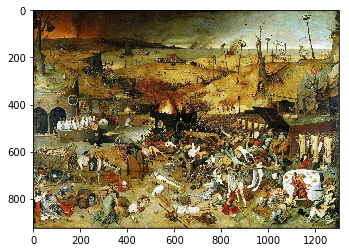

In [199]:
img = cv2.imread('C:/Users/BF-MSTR/Google Drive/Wallpapers/1562 - Netherlands - Pieter Brueghel the Elder - Triumph of Death.jpg',cv2.COLOR_RGB2LAB)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Data is loaded and cleaned, let's create some plots to understand it

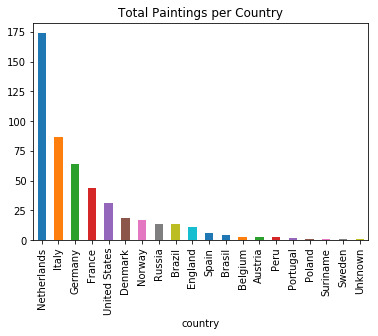

In [76]:
# List the countries with a minimun count of paintings
country_count = paintings_df.groupby('country').size()
min_paintings_per_country = 10
top_countries = set(country_count[country_count.values > min_paintings_per_country].index)
#print(country_count.sort_values(ascending=False))
country_count.sort_values(ascending=False).plot.bar(title='Total Paintings per Country')
#print(top_countries)

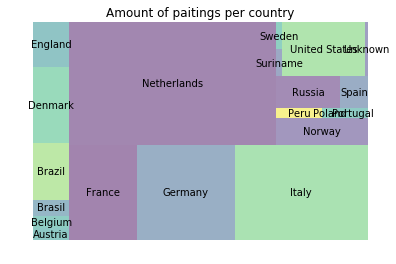

In [77]:
# Squareplot for countries
x = list(paintings_df.groupby('country').size().index)
y = paintings_df.groupby('country').size().values

squarify.plot(sizes=y, label=x, alpha=.5 )
plt.axis('off')
plt.title('Amount of paitings per country')
plt.show()

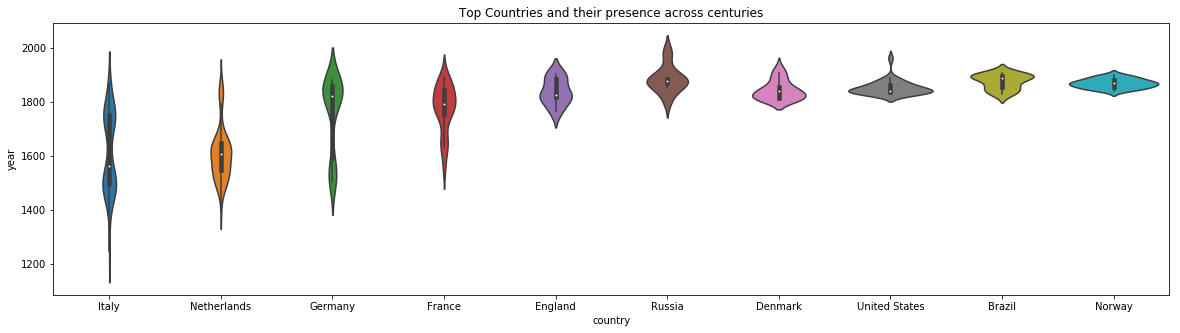

In [82]:
# Violin plot - 
dims = (20, 5)

plt.subplots(figsize = dims)
sns.violinplot(x=paintings_df[paintings_df['country'].isin(top_countries)].country
               , y=pd.to_numeric(paintings_df[paintings_df['country'].isin(top_countries)].year)
               ).set_title('Top Countries and their presence across centuries')
plt.show()

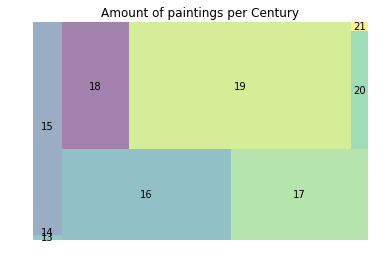

In [92]:
# Squareplot for centuries
x = list(paintings_df.groupby('century').size().index)
y = paintings_df.groupby('century').size().values

squarify.plot(sizes=y, label=x, alpha=.5 )
plt.axis('off')
plt.title('Amount of paintings per century')
plt.show()

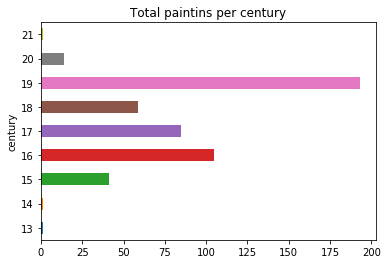

In [93]:
# List the centuries with a minimun count of paintings
century_count = paintings_df.groupby('century').size()
min_paintings_per_century = 40
top_centuries = set(century_count[century_count.values > min_paintings_per_century].index)
#print(century_count)
#print(top_centuries)
century_count.plot.barh(title='Total paintins per century')

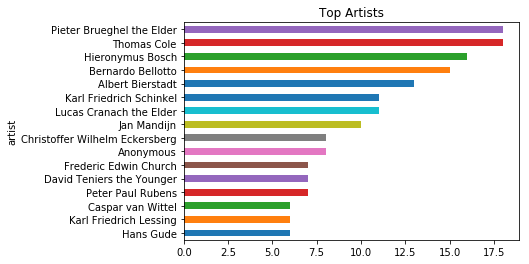

In [13]:
# List the centuries with a minimun count of paintings
artist_count = paintings_df.groupby('artist').size()
min_paintings_per_artist = 5
top_artists = set(artist_count[artist_count.values > min_paintings_per_artist].index)
#print(artist_count.sort_values(ascending=False))
#print(top_artists)
artist_count[top_artists].sort_values(ascending=True).plot.barh(title='Top Artists')

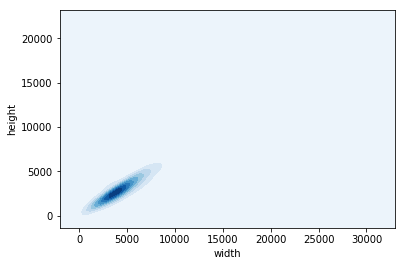

In [17]:
# Density of image dimensions
sns.kdeplot(paintings_df.width, paintings_df.height, cmap="Blues", shade=True, shade_lowest=True)

# Data prep - Predict Century

to follow: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/image_retraining/retrain.py


In [ ]:
# Subset original DF, pick up only big enough centuries
train_df = paintings_df[paintings_df.century.isin(top_centuries)]
#print(paintings_df.groupby('century').size())
#print(train_df.groupby('century').size())
#train_df.shape

In [ ]:
classes = set(train_df.century)
num_classes = len(classes)

#train_path='training_data'
train_path = train_df.image_path

# validation split
validation_size = 0.2

# batch size
batch_size = 16

data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)